In [4]:
import sys
import os
from metient.metient import *
from metient.util import data_extraction_util as dutil

REPO_DIR = os.path.join(os.getcwd(), "../../")
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'data/tracerx_nsclc/')
INPUT_DIR = os.path.join(TRACERX_DATA_DIR, 'tracerx_provided_patient_data', )
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs", "test")

def run_conipher_patient(patient, weights):
    space = "x"*44
    tsv_fn = os.path.join(INPUT_DIR, f"{patient}_SNVs.tsv")
    print(tsv_fn)
    print(f"{space} PATIENT {patient} {space}")
    tree_fn = os.path.join(INPUT_DIR, f"{patient}_tree.txt")
    tree = dutil.get_adjacency_matrix_from_txt_edge_list(tree_fn)
    print_config = PrintConfig(visualize=True, verbose=False, k_best_trees=30)
    evaluate_label_clone_tree(tree, tsv_fn, weights, print_config, OUTPUT_DIR, patient, O=None,
                              bias_weights=True, solve_polytomies=True, batch_size=1024)
    

  0%|          | 0/166 [00:00<?, ?it/s]

/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../data/tracerx_nsclc/tracerx_provided_patient_data/CRUK0010_SNVs.tsv
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0010 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../data/tracerx_nsclc/tracerx_provided_patient_data/CRUK0010_SNVs.tsv
ordered_sites ['primary_SU_T1', 'LN_SU_FLN1', 'metachronousMet_BR_LN1', 'metachronousMet_BR_LN2', 'metachronousMet_BR_LN3']


 38%|███▊      | 63/166 [00:01<00:02, 40.05it/s]

poly_res.children_of_polys [4, 10, 11, 13, 27, 28]
poly_res.resolver_indices [15, 16]
poly_res.resolver_index_to_parent_idx {15: 12, 16: 12}


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:502: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_tensor = torch.tensor(adj_matrices, dtype=torch.float32)
 41%|████      | 68/166 [00:02<00:06, 14.42it/s]

13 [5, 13, 14, 21, 29, 30] True
3 [2, 3, 6, 18, 19, 22] True
16 [7, 11, 16, 23, 26, 28] True
1 [1, 9, 17, 24] True
15 [4, 15, 20, 27] True


100%|██████████| 166/166 [00:04<00:00, 39.32it/s]


pareto_metrics {(4, 4, 1)}
batch nums [1, 3]
# final solutions: 2
CRUK0010_primary_SU_T1
30 unique trees were not found (2 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

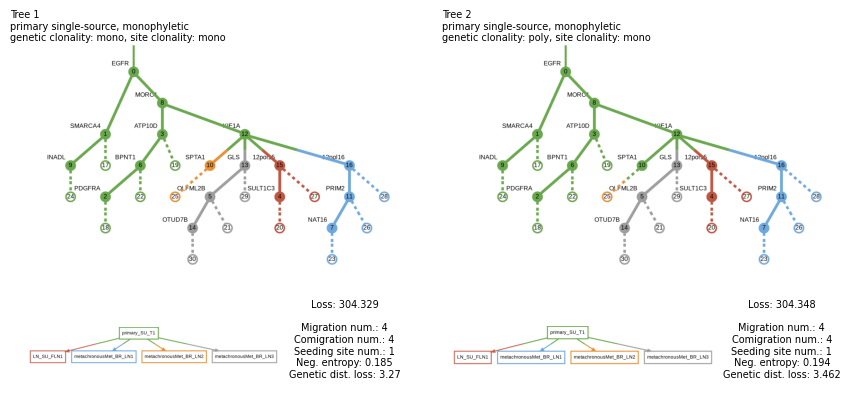

In [5]:
%%prun
weights = Weights(mig=1, comig=50, seed_site=100, reg=2, gen_dist=0.1, organotrop=0.0)

run_conipher_patient("CRUK0010", weights)

In [ ]:

tracerx_reported_counts = {
    "Brain":6, "Chest wall":1, "Bronchus":4,"Pleura":2,"Rib":2,
    "Liver":6,"Flank":1,"Femur":1,"Neck LN":2,"Primary LN":148,
    "Recurrence LN":20,"Scapula":1,"Axillary LN":1,"Recurrence lung":13,
    "Primary surgery satellite lesion lung":3, "Adrenal gland":1,
    "Subphrenic mass":1, "Skin":3, "Paravertebral":1, "Peritoneum":1,
    "Lung":0
}

total = sum([tracerx_reported_counts[key] for key in tracerx_reported_counts])
tracerx_reported_freqs = {key:float(tracerx_reported_counts[key]/total) for key in tracerx_reported_counts}
print(tracerx_reported_freqs)
def get_organotropism_matrix_from_tracerx(unique_sites, tracerx_map):
    mapped_sites = [tracerx_map[site] for site in unique_sites]
    organotrop_arr = np.zeros(len(mapped_sites))
    for i, metastatic_site in enumerate(mapped_sites):
        organotrop_arr[i] = tracerx_reported_freqs[metastatic_site]
    return torch.tensor(organotrop_arr, dtype = torch.float32)


In [2]:
import pandas as pd
no_cna_dir = os.path.join(TRACERX_DATA_DIR, "CRUK0762_no_cna_testing")
dutil.pool_input_tsv(os.path.join(no_cna_dir, "CRUK0762_SNVs.tsv"), no_cna_dir, f"tmp_CRUK0762")
df = pd.read_csv(os.path.join(no_cna_dir,"tmp_CRUK0762_clustered_SNVs.tsv"),sep="\t")
df['implied F no CNA'] = df.apply(lambda row: row['var']/(0.5*row['ref']+row['var']), axis=1)
df = df[['anatomical_site_label', 'cluster_index', 'implied F no CNA']]
matrix_df = df.pivot(index='cluster_index', columns='anatomical_site_label', values='implied F no CNA')
matrix_df.to_csv(os.path.join(no_cna_dir,"CRUK0762_clustered_SNVs_no_cnas.tsv"), sep="\t")


NameError: name 'os' is not defined

In [5]:
df

,anatomical_site_label,cluster_index,implied F no CNA
0,LN_SU_FLN1,0,0.201
1,LN_SU_FLN2,0,0.128
2,LN_SU_FLN3,0,0.149
3,LN_SU_LN1,0,0.138
4,LN_SU_LN2,0,0.153
...,...,...,...
83,LN_SU_FLN2,20,0.000
84,LN_SU_FLN3,20,0.000
85,LN_SU_LN1,20,0.000
86,LN_SU_LN2,20,0.000
